# Nettverksanalyse i sgis
https://github.com/statisticsnorway/ssb-sgis

Notebook-en kan kjøres i dapla.

Eller åpnes her: https://nbviewer.org/github/statisticsnorway/intro_til_geopandas/blob/main/nettverksanalyse.ipynb

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sgis as sg

## Hente data

Henter data for veger og bygningspunkter i Oslo og to nabokommuner (Bærum og Nordre follo).

In [2]:
kartdata = "ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data"

veger = sg.read_geopandas(
    f"{kartdata}/2022/NVDB_ruteplan_nettverk_p20220703_v1.parquet",
    filters=[("KOMMUNENR", "in", ('0301', '3024', '3020'))],
    columns=["oneway", "drivetime_fw", "drivetime_bw", "KOMMUNENR", "geometry"]
)

veger.sort_values("oneway")

,oneway,drivetime_fw,drivetime_bw,KOMMUNENR,geometry
119702,B,0.216611,0.216611,0301,MULTILINESTRING Z ((258028.440 6674249.890 413...
1415383,B,0.062602,0.062602,0301,MULTILINESTRING Z ((265347.560 6654750.570 230...
1415382,B,0.053945,0.053945,0301,MULTILINESTRING Z ((268027.000 6646538.600 160...
1415381,B,0.135625,0.135625,0301,MULTILINESTRING Z ((262066.673 6655401.898 212...
1415380,B,0.111156,0.111156,0301,MULTILINESTRING Z ((268124.331 6646443.504 160...
...,...,...,...,...,...
1472723,TF,-1.000000,0.101898,0301,MULTILINESTRING Z ((263061.100 6651519.800 55....
1022450,TF,-1.000000,0.019263,3024,MULTILINESTRING Z ((247488.922 6649695.927 26....
1022445,TF,-1.000000,0.005270,3024,MULTILINESTRING Z ((247490.918 6649692.213 26....
1022515,TF,-1.000000,0.028626,3024,MULTILINESTRING Z ((248167.570 6649285.687 31....


In [3]:
aar = 2022

bygningspunktsti = f"ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data/{aar}/SMAT_bygg_punkt_p{aar}_v1.parquet"

bygg = sg.read_geopandas(
    bygningspunktsti,
    filters=[("KOMMUNENR", "in", ('0301', '3024', '3020'))],
    columns=["KOMMUNENR", "geometry"]
)

bygg

,KOMMUNENR,geometry
2126288,3020,POINT (269263.000 6617407.000)
2126460,3020,POINT (267831.000 6616413.000)
2126732,3020,POINT (270268.000 6617244.000)
2126740,3020,POINT (268989.000 6617320.000)
2126749,3020,POINT (269058.000 6617321.000)
...,...,...
2704094,0301,POINT (258558.000 6667933.000)
2704589,0301,POINT (258492.000 6667941.000)
2704605,0301,POINT (258532.000 6668042.000)
2704777,0301,POINT (256610.000 6668631.000)


Lager start- og sluttpunkter med unike index-er.

In [4]:
origins = bygg.sample(1000)

origins.index = np.arange(0, 1000)

origins

,KOMMUNENR,geometry
0,0301,POINT (259795.000 6650411.000)
1,3024,POINT (254824.000 6651329.000)
2,0301,POINT (256666.000 6650023.000)
3,0301,POINT (258060.000 6652059.000)
4,0301,POINT (258652.000 6654487.000)
...,...,...
995,3024,POINT (248549.000 6646715.000)
996,3024,POINT (251936.000 6647871.000)
997,0301,POINT (272646.000 6651839.000)
998,0301,POINT (273150.000 6652954.000)


In [5]:
destinations = bygg.sample(1000)

destinations.index = np.arange(1000, 2000)

destinations

,KOMMUNENR,geometry
1000,0301,POINT (262902.000 6654733.000)
1001,0301,POINT (259696.000 6653154.000)
1002,0301,POINT (258712.000 6648331.000)
1003,0301,POINT (272996.000 6654773.000)
1004,0301,POINT (264847.000 6652218.000)
...,...,...
1995,0301,POINT (265219.000 6651925.000)
1996,0301,POINT (258781.000 6647840.000)
1997,0301,POINT (264729.000 6643589.000)
1998,0301,POINT (266207.000 6642744.000)


## Gjør klar til nettverksanalyse
Man starter med å lage et "nettverk" av vegene.

In [6]:
nw = sg.DirectedNetwork(veger)
nw

DirectedNetwork(5663 km, percent_bidirectional=0)

Legg merke til at null prosent av vegene går i begge retninger. Det er fordi man må snu veger
som går motsatt/begge retning(er).

Fjerne samtidig nettverksøyer.

In [7]:
nw = (
    sg.DirectedNetwork(veger)
    .remove_isolated()
    .make_directed_network_norway()
)
nw

DirectedNetwork(9522 km, percent_bidirectional=85)

In [ ]:
nw.gdf.minutes

Nå har vi nettverk. Og så trenger vi noen regler.

In [8]:
rules = sg.NetworkAnalysisRules(
    weight="minutes", 
    search_tolerance=500, # meter
    search_factor=10,
)
rules

NetworkAnalysisRules(weight='minutes', search_tolerance=500, search_factor=10, split_lines=False, nodedist_multiplier=None, nodedist_kmh=None)

Så kan nettverket og reglene puttes inni NetworkAnalysis-klassen:

In [9]:
nwa = sg.NetworkAnalysis(network=nw, rules=rules)
nwa

NetworkAnalysis(
    network=DirectedNetwork(9522 km, percent_bidirectional=85),
    rules=NetworkAnalysisRules(weight=minutes, search_tolerance=500, search_factor=10, split_lines=False, ...),
    log=True, detailed_log=True,
)

## Finn rutefrekvens

In [10]:
fra = origins.loc[origins.KOMMUNENR == "0301"].sample(25)
til = destinations.loc[destinations.KOMMUNENR == "0301"].sample(25)

In [11]:
frequencies = nwa.get_route_frequencies(fra, til)

frequencies.nlargest(3, "frequency")

,KOMMUNENR,connected,drivetime_bw,drivetime_fw,idx_orig,meters,minutes,frequency,n_source,n_target,oneway,source,source_wkt,target,target_wkt,geometry
193805,0301,1.0,-1.0,NaN,1443423,14.374363,0.019837,113.0,3,3,FT,95331,POINT (265332.9000000004 6647153.6),95160,POINT (265338.0 6647140.4),"LINESTRING Z (265332.900 6647153.600 131.360, ..."
189031,0301,1.0,-1.0,NaN,688850,0.498768,0.000513,112.0,2,2,FT,91827,POINT (265179.2019999996 6651549.722999999),91828,POINT (265178.76099999994 6651549.956),"LINESTRING Z (265179.202 6651549.723 81.532, 2..."
189030,0301,1.0,-1.0,NaN,688842,0.998375,0.001027,112.0,2,2,FT,91826,POINT (265180.0860000001 6651549.259),91827,POINT (265179.2019999996 6651549.722999999),"LINESTRING Z (265180.086 6651549.259 81.473, 2..."


Kartlegg resultatene.

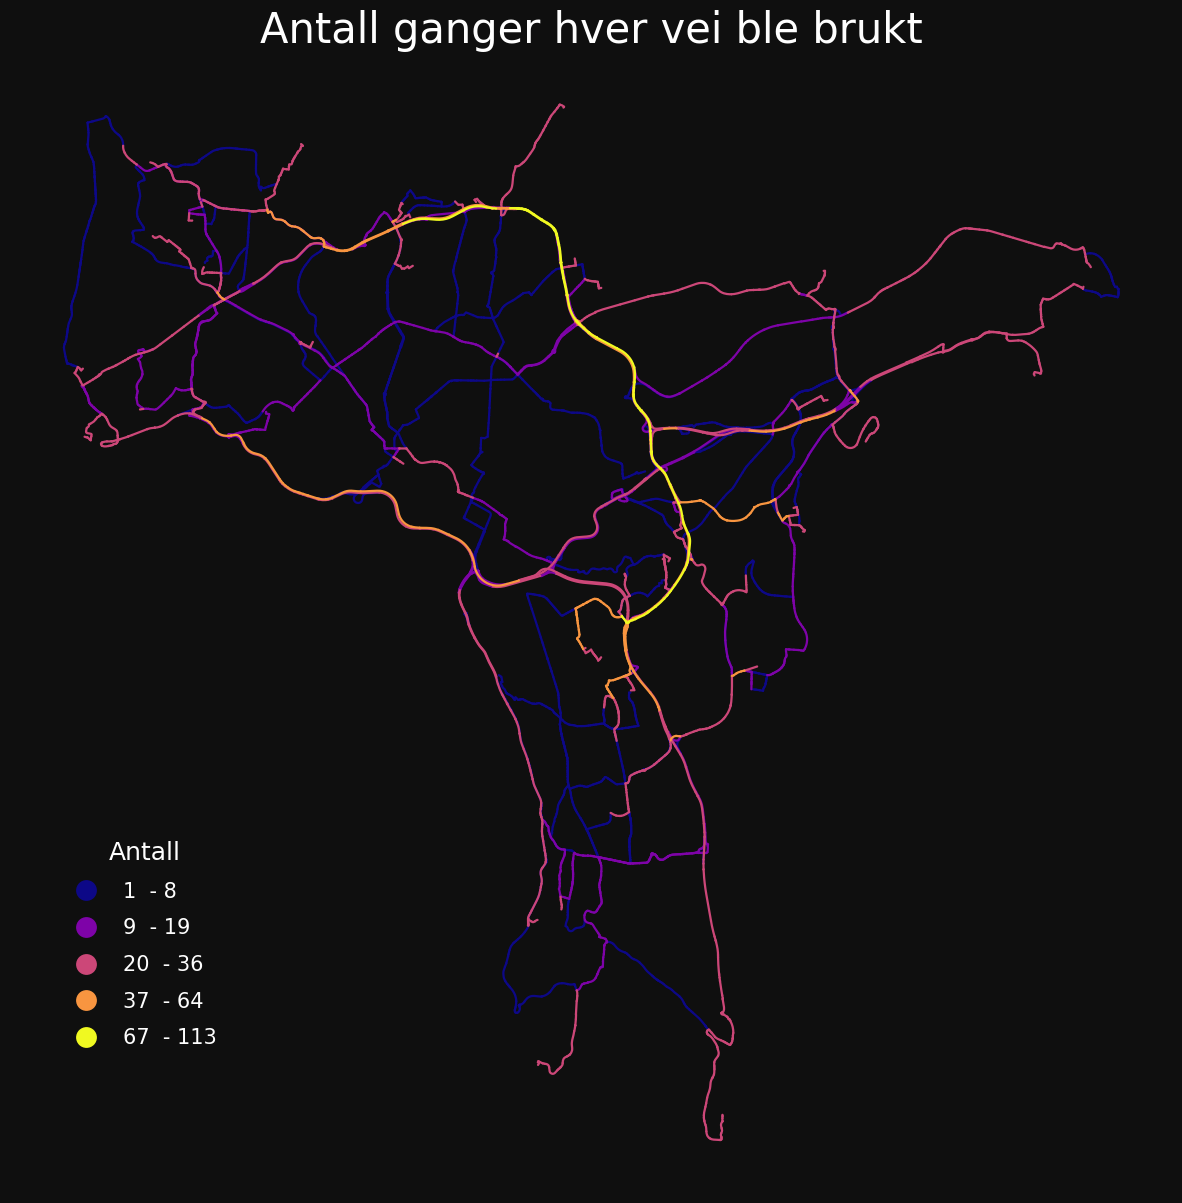

In [12]:
m = sg.ThematicMap(sg.buff(frequencies, 18), column="frequency", size=15)
m.black = True
m.cmap = "plasma" # fargepaletten
m.title = "Antall ganger hver vei ble brukt"
m.legend.title = "Antall"
m.plot()

## Finn raskeste rute
Velger ett startpunkt for illustrasjons skyld.

In [13]:
origin = bygg.loc[[2_470_929]]

In [14]:
routes = nwa.get_route(
    origins=origin,
    destinations=destinations.sample(15),
)

routes

,origin,destination,minutes,geometry
0,2470929,1749,18.599489,MULTILINESTRING Z ((261352.158 6649521.080 6.6...
1,2470929,1176,23.048989,MULTILINESTRING Z ((261352.158 6649521.080 6.6...
2,2470929,1292,9.635767,MULTILINESTRING Z ((263171.800 6651250.200 46....
3,2470929,1372,10.302951,MULTILINESTRING Z ((267591.300 6650009.900 86....
4,2470929,1166,3.586202,MULTILINESTRING Z ((262663.901 6650248.801 6.0...
5,2470929,1409,22.795843,MULTILINESTRING Z ((263437.600 6637309.800 70....
6,2470929,1002,13.370341,MULTILINESTRING Z ((261352.158 6649521.080 6.6...
7,2470929,1539,24.110953,MULTILINESTRING Z ((261352.158 6649521.080 6.6...
8,2470929,1538,15.356594,MULTILINESTRING Z ((257837.656 6654546.994 198...
9,2470929,1764,10.867091,MULTILINESTRING Z ((262860.400 6650873.440 32....


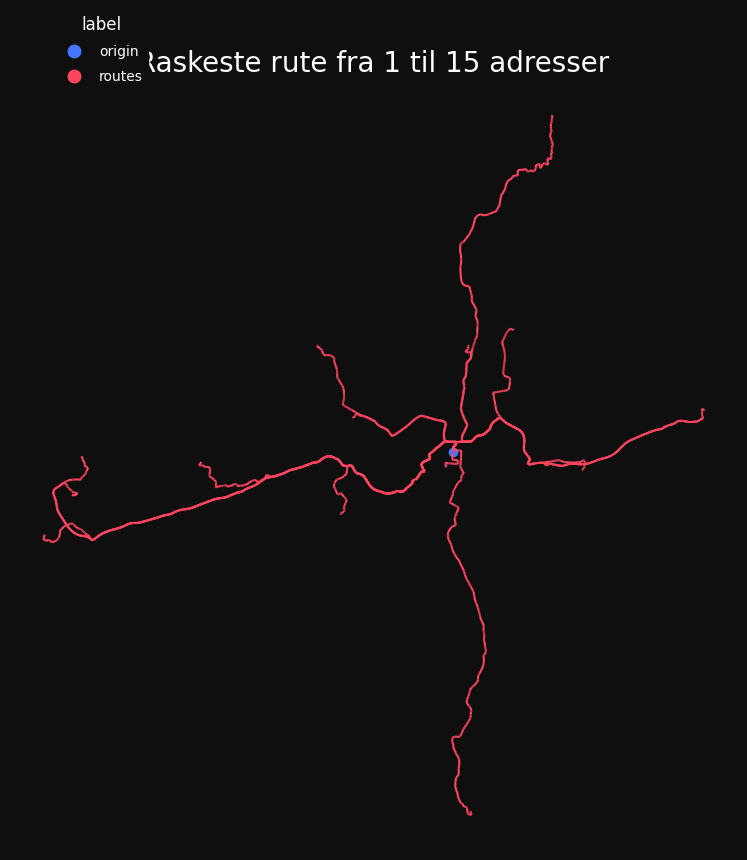

In [15]:
m = sg.ThematicMap(routes, origin, size=10)
m.black = True
m.title = "Raskeste rute fra 1 til 15 adresser"
m.plot()

### Service area

In [16]:
service_areas = nwa.service_area(
    origin,
    breaks=np.arange(1, 11),
)

service_areas

,origin,minutes,geometry
0,2470929,1,MULTILINESTRING Z ((262850.023 6650817.997 30....
1,2470929,2,MULTILINESTRING Z ((263052.902 6651086.944 38....
2,2470929,3,MULTILINESTRING Z ((262834.800 6651311.300 48....
3,2470929,4,MULTILINESTRING Z ((262750.930 6651840.320 63....
4,2470929,5,MULTILINESTRING Z ((261699.300 6650469.800 37....
5,2470929,6,MULTILINESTRING Z ((264990.250 6650276.370 76....
6,2470929,7,MULTILINESTRING Z ((265262.829 6650519.242 78....
7,2470929,8,MULTILINESTRING Z ((264348.673 6648271.134 17....
8,2470929,9,MULTILINESTRING Z ((266909.769 6651075.250 114...
9,2470929,10,MULTILINESTRING Z ((263448.780 6645754.660 7.3...


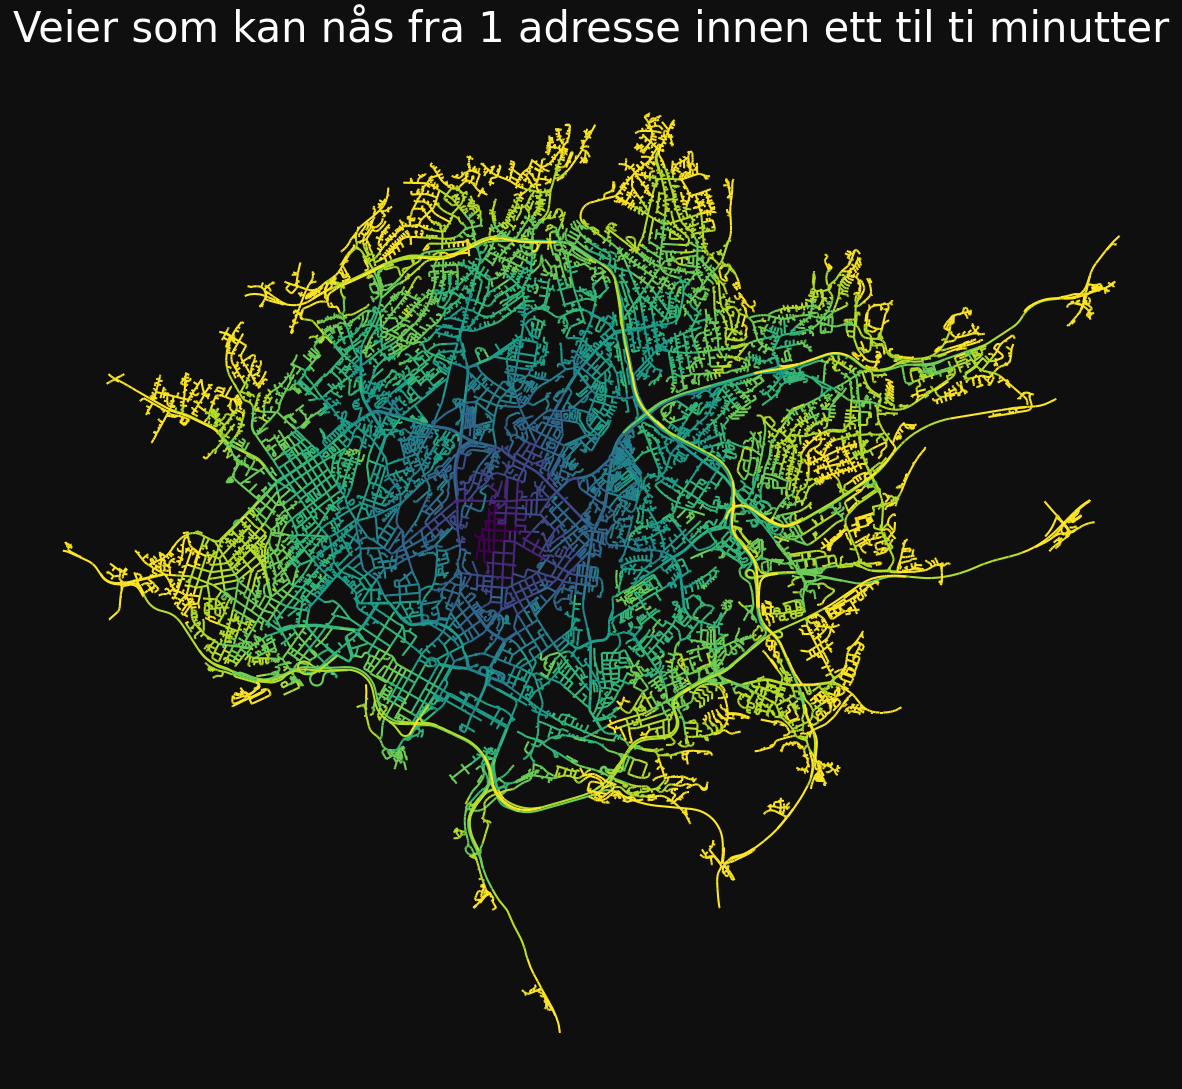

In [17]:
m = sg.ThematicMap(service_areas, column="minutes", size=15)
m.black = True
m.k = 10
m.title = "Veier som kan nås fra 1 adresse innen ett til ti minutter"
m.legend = False
m.plot()

Sjekk loggen:

In [18]:
nwa.log

,endtime,minutes_elapsed,method,origins_count,destinations_count,percent_missing,cost_mean,isolated_removed,percent_bidirectional,weight,...,split_lines,nodedist_multiplier,nodedist_kmh,cost_p25,cost_median,cost_p75,cost_std,rowwise,breaks,dissolve
0,2023-04-13 09:12:54,0.4,get_route_frequencies,25,25.0,0.0,0.067920,True,85,minutes,...,False,None,None,0.013566,0.041115,0.087669,0.087965,NaN,NaN,NaN
1,2023-04-13 09:13:08,0.2,get_route,1,15.0,0.0,16.142726,True,85,minutes,...,False,None,None,10.585021,14.639584,22.771968,7.058067,False,NaN,NaN
2,2023-04-13 09:13:16,0.1,service_area,1,NaN,0.0,5.500000,True,85,minutes,...,False,None,None,3.250000,5.500000,7.750000,3.027650,NaN,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10",True


### Reisetider: OD Cost Matrix

In [19]:
od = nwa.od_cost_matrix(
    origins,
    destinations,
)
od

,origin,destination,minutes
0,0,1000,13.100170
1,0,1001,8.177093
2,0,1002,6.520478
3,0,1003,22.092861
4,0,1004,12.859682
...,...,...,...
999995,999,1995,29.011827
999996,999,1996,25.270308
999997,999,1997,32.722910
999998,999,1998,34.749524


Sjekk hvor mange prosent som mangler:

In [20]:
od.minutes.isna().mean() * 100

1.4944000000000002

Kolonnene 'origin' og 'destination' bruker index-en til inputene.

Man kan derfor enkelt koble resultatene med start- og sluttpunktene:

In [21]:
origins_joinet = origins.join(od.set_index("origin"))
origins_joinet

,KOMMUNENR,geometry,destination,minutes
0,0301,POINT (259795.000 6650411.000),1000,13.100170
0,0301,POINT (259795.000 6650411.000),1001,8.177093
0,0301,POINT (259795.000 6650411.000),1002,6.520478
0,0301,POINT (259795.000 6650411.000),1003,22.092861
0,0301,POINT (259795.000 6650411.000),1004,12.859682
...,...,...,...,...
999,3024,POINT (248397.000 6654144.000),1995,29.011827
999,3024,POINT (248397.000 6654144.000),1996,25.270308
999,3024,POINT (248397.000 6654144.000),1997,32.722910
999,3024,POINT (248397.000 6654144.000),1998,34.749524


In [22]:
destinations_joinet = destinations.join(od.set_index("destination"))
destinations_joinet

,KOMMUNENR,geometry,origin,minutes
1000,0301,POINT (262902.000 6654733.000),0,13.100170
1000,0301,POINT (262902.000 6654733.000),1,15.317153
1000,0301,POINT (262902.000 6654733.000),2,14.330764
1000,0301,POINT (262902.000 6654733.000),3,12.818597
1000,0301,POINT (262902.000 6654733.000),4,12.438804
...,...,...,...,...
1999,3024,POINT (255677.000 6649918.000),995,11.719598
1999,3024,POINT (255677.000 6649918.000),996,7.102850
1999,3024,POINT (255677.000 6649918.000),997,21.409819
1999,3024,POINT (255677.000 6649918.000),998,24.563791


Eller koble på aggregert data:

In [23]:
origins["minutes_mean"] = od.groupby("origin").minutes.mean()
origins["n_missing"] = len(origins) - od.groupby("origin", dropna=False).minutes.count()
origins

,KOMMUNENR,geometry,minutes_mean,n_missing
0,0301,POINT (259795.000 6650411.000),16.281255,8
1,3024,POINT (254824.000 6651329.000),18.854441,8
2,0301,POINT (256666.000 6650023.000),17.953683,8
3,0301,POINT (258060.000 6652059.000),18.984394,8
4,0301,POINT (258652.000 6654487.000),20.815347,8
...,...,...,...,...
995,3024,POINT (248549.000 6646715.000),24.232884,8
996,3024,POINT (251936.000 6647871.000),20.257442,8
997,0301,POINT (272646.000 6651839.000),22.939738,8
998,0301,POINT (273150.000 6652954.000),24.830315,8


La oss undersøke hvilke punkter som har mye manglende data. 

In [24]:
# gjør kolonnen til tekst for å kunne huke av/på verdiene i explore
origins["n_missing_cat"] = origins.n_missing.astype(str)
sg.explore(origins, column="n_missing_cat")

In [25]:
sg.explore(origins, column="minutes_mean", scheme="quantiles")

Hvis man vil bruke en kolonne som id-er heller enn index-en, kan man sette index-en inni funksjonen:

In [26]:
od = nwa.od_cost_matrix(
    origins.set_index("KOMMUNENR"),
    destinations,
)

od

,origin,destination,minutes
0,0301,1000,13.100170
1,0301,1001,8.177093
2,0301,1002,6.520478
3,0301,1003,22.092861
4,0301,1004,12.859682
...,...,...,...
999995,3024,1995,29.011827
999996,3024,1996,25.270308
999997,3024,1997,32.722910
999998,3024,1998,34.749524


Så kan man oppsummere for kommunene direkte:

In [27]:
oppsummert_kommunevis = od.groupby("origin").agg(
    minutes_mean=("minutes", "mean"),
    count=("minutes", "count"),
)

oppsummert_kommunevis.index.name = "KOMMUNENR"
oppsummert_kommunevis.reset_index()

,KOMMUNENR,minutes_mean,count
0,0301,19.284739,610080
1,3020,29.210423,129952
2,3024,22.702046,245024


Med lines=True får man rette linjer, så man lettere kan undersøke resultatene.

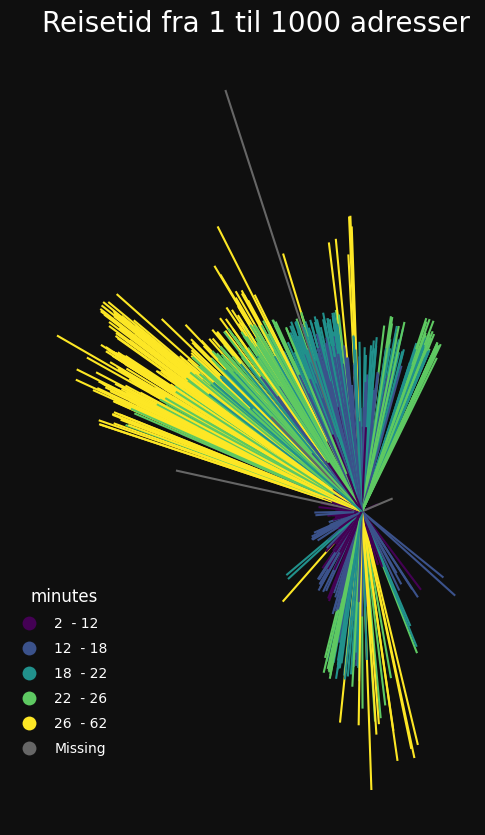

In [28]:
od = nwa.od_cost_matrix(
    origins.sample(1),
    destinations,
    lines=True
)

m = sg.ThematicMap(od, column="minutes", size=10)
m.black = True
m.title = "Reisetid fra 1 til 1000 adresser"
m.scheme = "quantiles"
m.plot()

## Finn raskeste k ruter
k = antall

,origin,destination,minutes,k,geometry
0,2470929,2538349,8.977744,1,MULTILINESTRING Z ((268199.200 6652524.500 148...
1,2470929,2538349,9.019577,2,MULTILINESTRING Z ((268199.200 6652524.500 148...
2,2470929,2538349,10.702815,3,MULTILINESTRING Z ((268199.200 6652524.500 148...
3,2470929,2538349,11.393830,4,MULTILINESTRING Z ((268199.200 6652524.500 148...
4,2470929,2538349,11.659811,5,MULTILINESTRING Z ((264854.200 6651595.600 126...
5,2470929,2538349,12.295612,6,MULTILINESTRING Z ((268199.200 6652524.500 148...
6,2470929,2538349,12.971575,7,MULTILINESTRING Z ((265431.010 6650971.850 94....
7,2470929,2538349,13.700938,8,MULTILINESTRING Z ((264052.396 6650829.193 53....
8,2470929,2538349,13.920801,9,MULTILINESTRING Z ((268656.950 6651694.641 118...
9,2470929,2538349,14.068021,10,MULTILINESTRING Z ((265226.515 6650674.617 88....


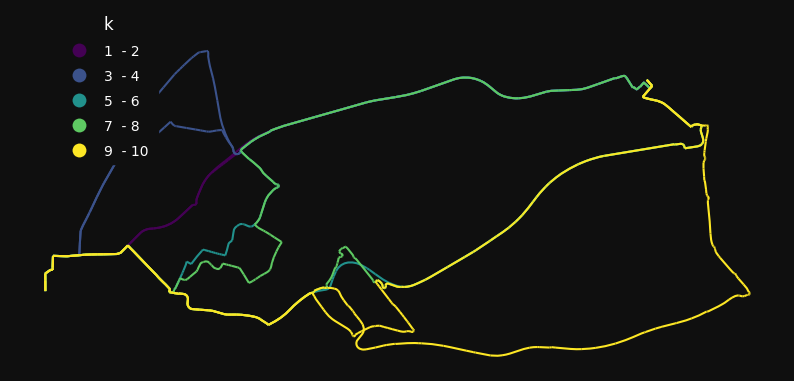

In [29]:
p1, p2 = bygg.loc[[2_470_929]], bygg.loc[[2_538_349]]

k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=1)

sg.qtm(k_routes, "k")

k_routes

Men kan stille strengere krav til hvor ulike rutene skal være. 

Med drop_middle_percent=50, fjernes midteste halvdel av ruta fra nettverket (midlertidig) før neste rute skal finnes.

/home/jovyan/arealrek/.venv/lib/python3.10/site-packages/sgis/maps/map.py:220: UserWarning: Could not create 5 classes.
  warnings.warn(f"Could not create {self._k} classes.")


,origin,destination,minutes,k,geometry
0,2470929,2538349,8.977744,1,MULTILINESTRING Z ((268199.200 6652524.500 148...
1,2470929,2538349,12.295612,2,MULTILINESTRING Z ((268199.200 6652524.500 148...
2,2470929,2538349,15.386203,3,MULTILINESTRING Z ((265313.000 6650960.400 97....
3,2470929,2538349,17.419792,4,MULTILINESTRING Z ((264052.396 6650829.193 53....
4,2470929,2538349,19.936433,5,MULTILINESTRING Z ((268199.200 6652524.500 148...
5,2470929,2538349,25.519504,6,MULTILINESTRING Z ((268656.950 6651694.641 118...


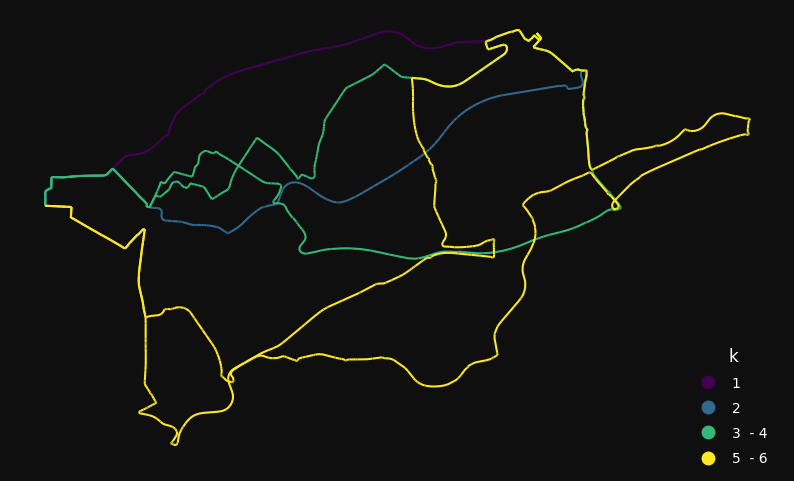

In [30]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=50)

sg.qtm(k_routes, "k")

k_routes

Her fant man bare seks ulike ruter. Med drop_middle_percent=100, finner man bare én rute:

,origin,destination,minutes,k,geometry
0,2470929,2538349,8.977744,1,MULTILINESTRING Z ((268199.200 6652524.500 148...


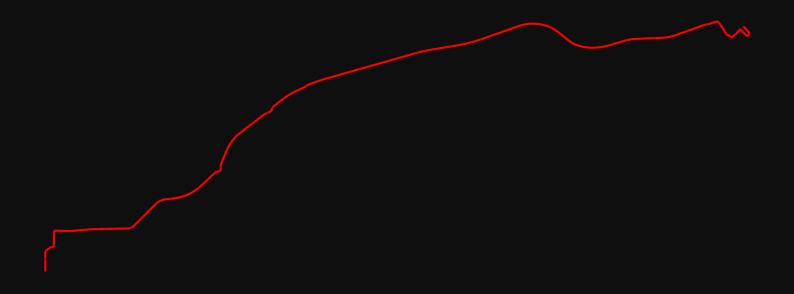

In [31]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=100)

sg.qtm(k_routes, "k", color="red")

k_routes